# Рекуррентные нейросети. Группа ИАД-5

<img src="https://habrastorage.org/web/a9b/1e6/40f/a9b1e640f6264b0a902e851eb5f29e08.png" width="150px">
<img src="https://habrastorage.org/web/5c8/0fa/c22/5c80fac224d449209d888d18ea1111a8.png" width="600px">

# Простая RNN для предсказания временных рядов

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pylab import rcParams
rcParams['figure.figsize'] = 17, 10

RANDOM_SEED = 123
# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
np.random.seed(RANDOM_SEED)

In [34]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset = df.values.astype('float32') # Keras умеет хавать только numpy-матрицы

Using TensorFlow backend.


In [32]:
df = pd.read_table("https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/airline/international-airline-passengers.csv", 
                   usecols=[1], skipfooter=2, sep=',', skip_blank_lines=True, engine="python")
df.columns = ["count"]

df.tail().T

139  140  141  142  143
count  606  508  461  390  432

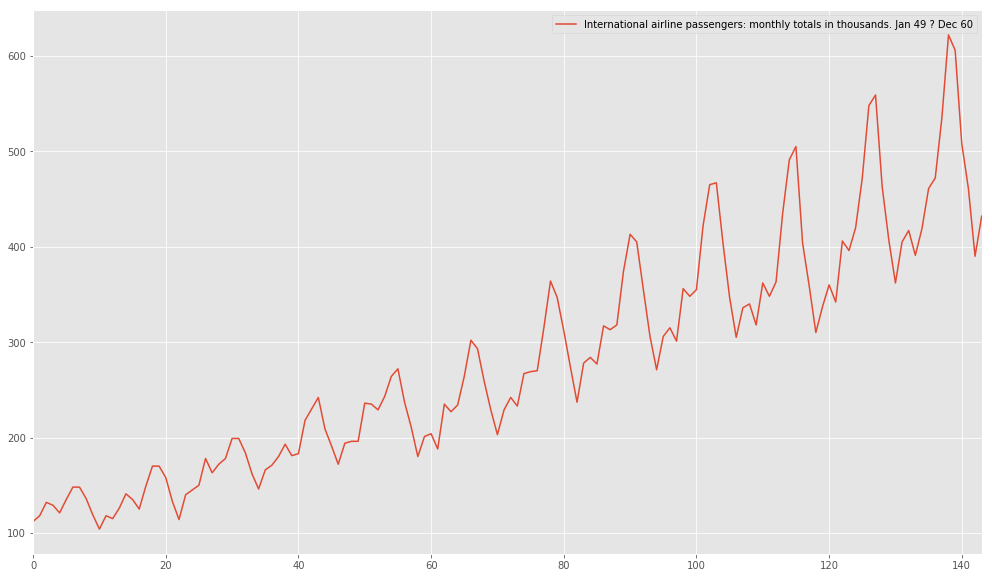

In [28]:
_ = df.plot()

In [70]:
# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dataset = scaler.fit_transform(dataset)

_ = plt.plot(dataset)

In [44]:
# разобьём данные на трейн (67%) и тест (33%). 
# В задачах предсказания временных рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(dataset.shape[0]/100*67)

train, test = dataset[:train_size], dataset[train_size:]
print(train.shape[0], test.shape[0], dataset.shape[0])

96 48 144


In [46]:
# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [48]:
# выводим размерность векторов trainX и testX
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(94, 1) (94,)
(46, 1) (46,)


In [50]:
_ = plt.plot(trainX)
_ = plt.plot(trainY)

In [51]:
# LSTM и RNN умеет работать с данными в таком формате [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [52]:
trainX.shape

(94, 1, 1)

In [59]:
# Конструируем нейросеть: simpleRNN+Dense, batch_size=1, loss=MSE, opt=ADAM
nn = Sequential(layers=[
    SimpleRNN(5, batch_input_shape=(1, 1, 1)),
    Dense(1)
])
nn.compile(optimizer="ADAM", loss="MSE")

# обучаем epochs=100
nn.fit(trainX, trainY, epochs=100, batch_size=1)

Epoch 1/100
94/94 [==============================] - 1s 12ms/step - loss: 0.0141
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 12/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 13/100
94/94 [================

0.0020088153

0.0098308967

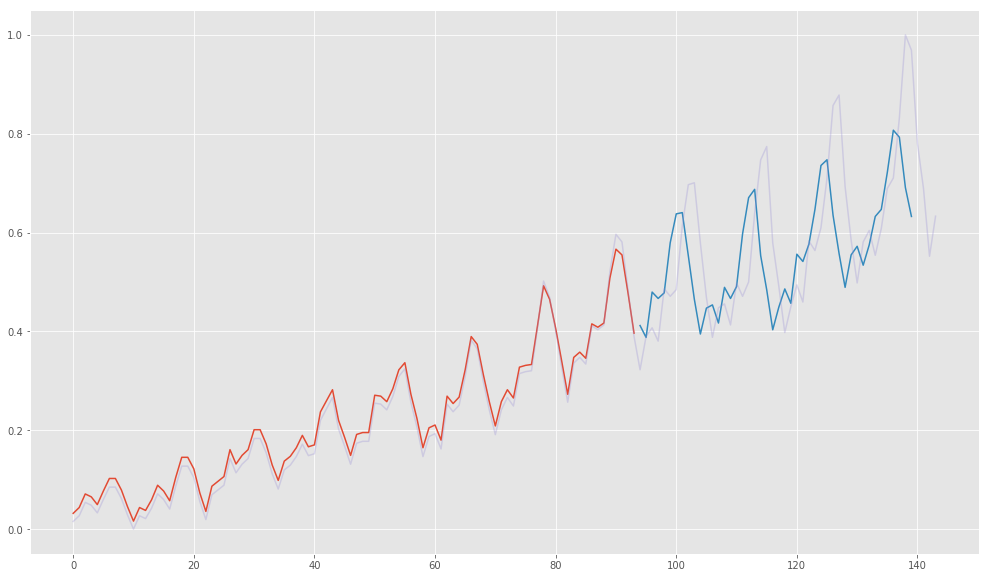

In [76]:
# получим предсказания для теста и трейна
pred_train = nn.predict(trainX, batch_size=1)
pred_test = nn.predict(testX, batch_size=1)

_ = plt.plot(np.arange(pred_train.shape[0]), pred_train)
_ = plt.plot(np.arange(pred_test.shape[0]) + pred_train.shape[0], pred_test)
_ = plt.plot(dataset, alpha=0.3)

# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
inv_pred_train = scaler.inverse_transform(pred_train)
inv_pred_test = scaler.inverse_transform(pred_test)

# посчитаем MSE для наших предсказаний
mean_squared_error(pred_train, trainY)
mean_squared_error(pred_test, testY)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='real timeseries')
plt.plot(trainPredictPlot, label='train preds')
plt.plot(testPredictPlot, label='test preds')
plt.legend()
plt.show()

# Сброс состояний перед каждым обучением

## Упражнение 1

In [ ]:
# TODO: проделываем те же махинации до стадии с обучением

In [ ]:
# Обучаем со сбросом состояний
for epoch in range(NB_EPOCHES):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=0)
    model.reset_states()

In [ ]:
# TODO: посмотрите на качество предсказаний

## LSTM
![lstm](https://habrastorage.org/web/67b/04f/73b/67b04f73b4c34ba38edfa207e09de07c.png)

## Упражнение 2

In [ ]:
from keras.layers import LSTM

# TODO проделайте все те же телодвижения с LSTM. Проверьте, есть ли прирост качества, и объясните полученные результаты

## Упражнение 3

In [73]:
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM

top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)

C:\Users\Dmitry\Miniconda3\envs\ml\lib\site-packages\keras\datasets\imdb.py:45: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


# Полезные ссылки
* [Статья](https://habrahabr.ru/company/wunderfund/blog/331310/) про RNN и LSTM на Хабре
* Годная [статья](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) с подробным разбором примера на Keras